In [41]:

import pandas as pd
import numpy as np
import nbimporter
import feature_engineering
from datetime import datetime, timedelta
from functools import reduce
import glob
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Preprocessing

In [42]:
%run Preprocessing.ipynb

## 1.1 Climate Data

### 1.1.1 Climate Data - Import 

In [43]:
climate_data = ["Temperature", "Precipitation"]
station_names = ["Berlin", "BW", "NRW"]
current_directory = os.getcwd()
temp_path = rf"{current_directory}\Wetter"
file_name = "produkt*"
date_column = "MESS_DATUM"
date_format = '%Y%m%d%H%M'

station_climate_list = []

for station in station_names:
    for data in climate_data:
        file_path =rf"{temp_path}\{station}\{data}"
        #print(file_path)
        temperature_dic = importing_climate_data(file_path, file_name, date_column, date_format)
        #print(temperature_dic)
        station_climate_list.append(temperature_dic)

print("done")

done


### 1.1.2 Climate Data - Downsampling to 15min steps

In [44]:
climate_resampled = []
for station in station_climate_list:
    resampled_dic = resampling_data(station, "15T")
    climate_resampled.append(resampled_dic)


print("done")

done


## 1.2 Football Data

### 1.2.1 Football Data - Importing

In [45]:

temp_path =r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'



football_dic = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)
print("done")

    

done


### 1.2.2 Football Data - Adding new columns for Matches at same time

In [46]:

football_dic_new = {}
for key, match_set in football_dic.items():

    results = new_col_match(match_set)        
        
    results.set_index("DateTime")
    football_dic_new[key] = results

print("done")

done


## 1.3 Electricity Data

### 1.3.1 Electricity Data - Importing and converting MWh to floats

In [47]:
temp_path =r"Stromverbrauch\Viertel"
file_name = "*.csv"
date_column = "Datum von"
date_format = "%d.%m.%Y %H:%M"

elec_dic = importing_electricity_data(temp_path, file_name, date_column, date_format)




## 1.4 Merging Dataframes, dropping unwanted columns, filling nans with during match with data from football dataset

In [48]:
dfs = []

unwantend_col_string = ["QN", "MESS_DATUM", 'Datum von', 'Datum bis', "eor", "STATIONS"]
#print(climate_resampled)
for key, elec in elec_dic.items():
    football = football_dic_new[key]
    electricity = elec
    climate_data = []
    for station in climate_resampled:
        climate_data.append(pd.DataFrame(station[key])) 

    merged_df = merging_data(electricity, football, climate_data, unwantend_col_string)
                       
    dfs.append(merged_df)

endresult_df = pd.concat(dfs, ignore_index = True)

print("done")


done


# 2. Feature Engineering

In [49]:
%run feature_engineering.ipynb

## 2.1 Correlation matrix

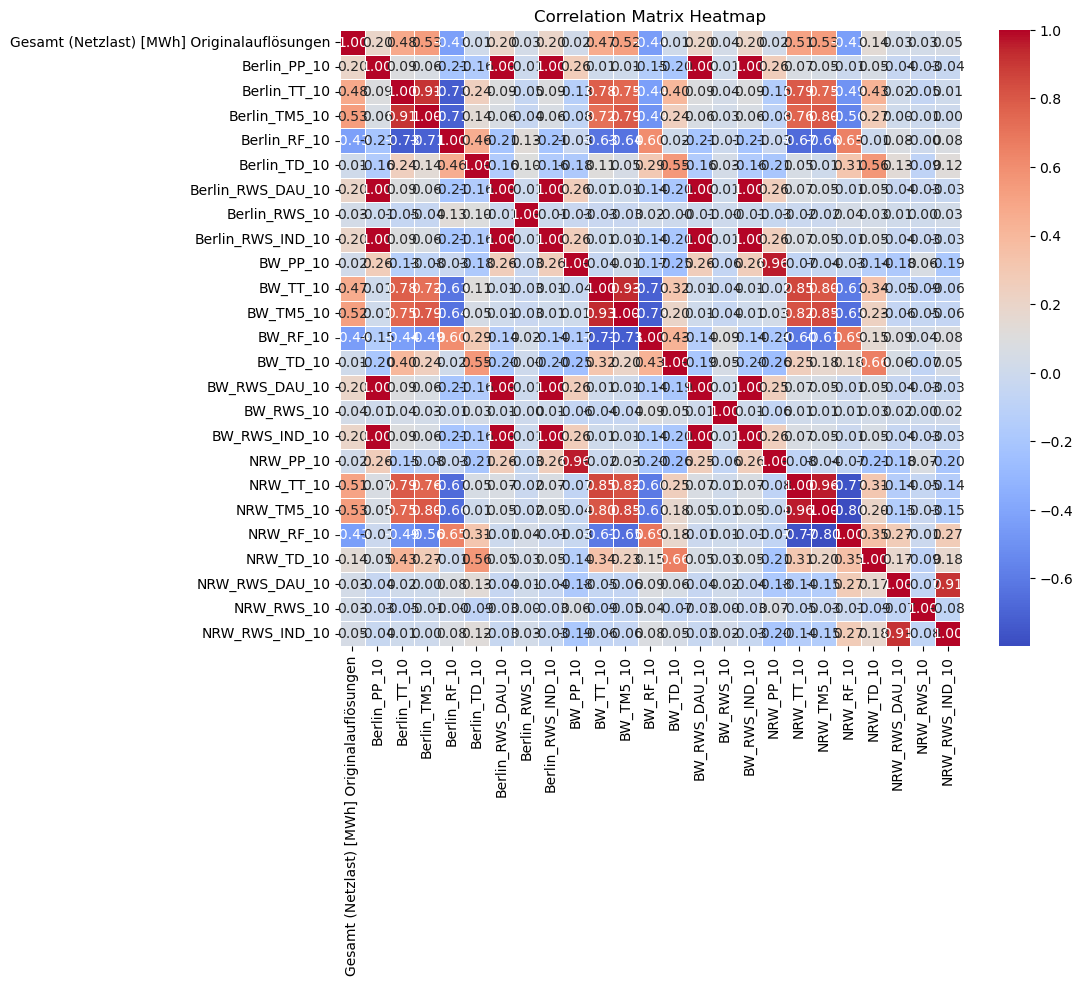

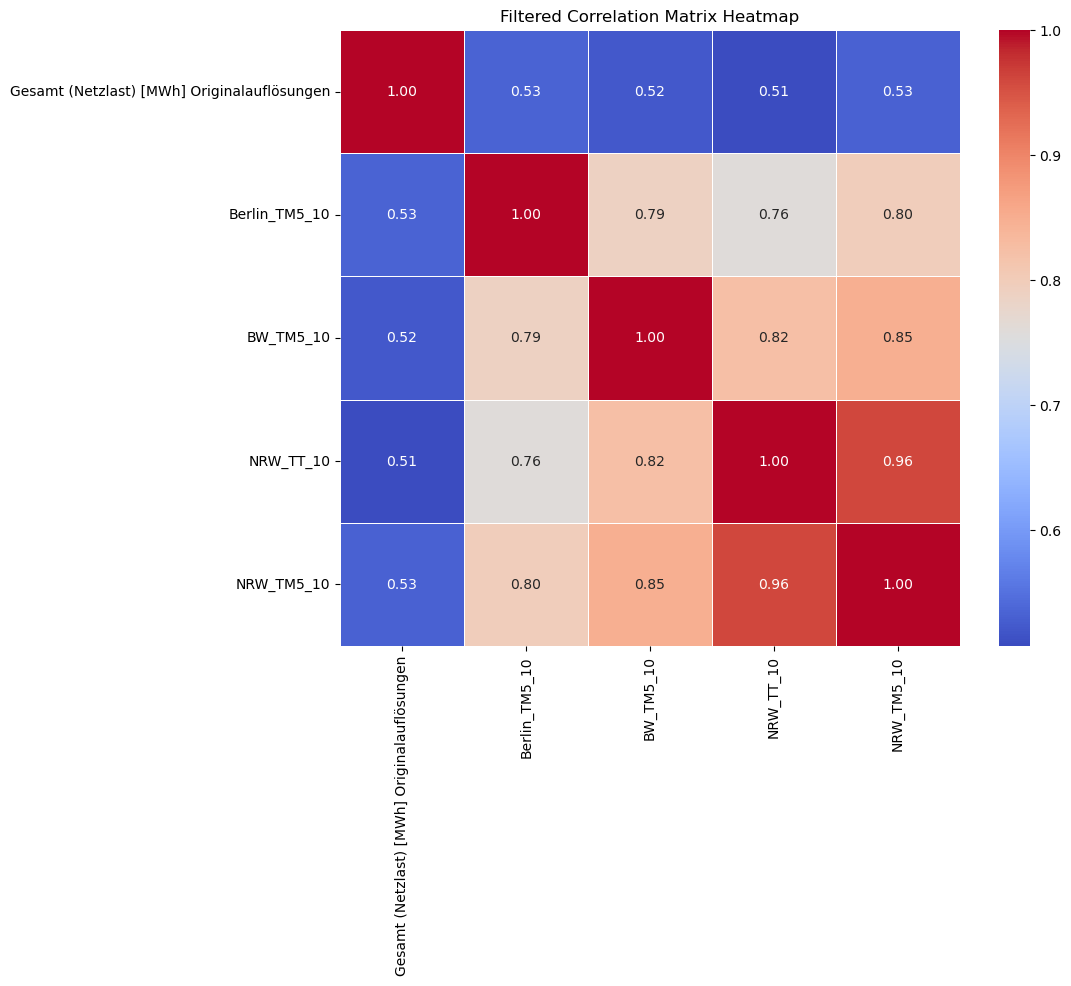

done


In [50]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
cut_off_limit = 0.5
#print(endresult_df)
#endresult_df.set_index("DateTime")
corr_df_input = endresult_df.copy()
df_filtered = correlation_matrix(corr_df_input, categorical_columns, cut_off_limit)
print("done")

## 2.2 Reducing dimensionality

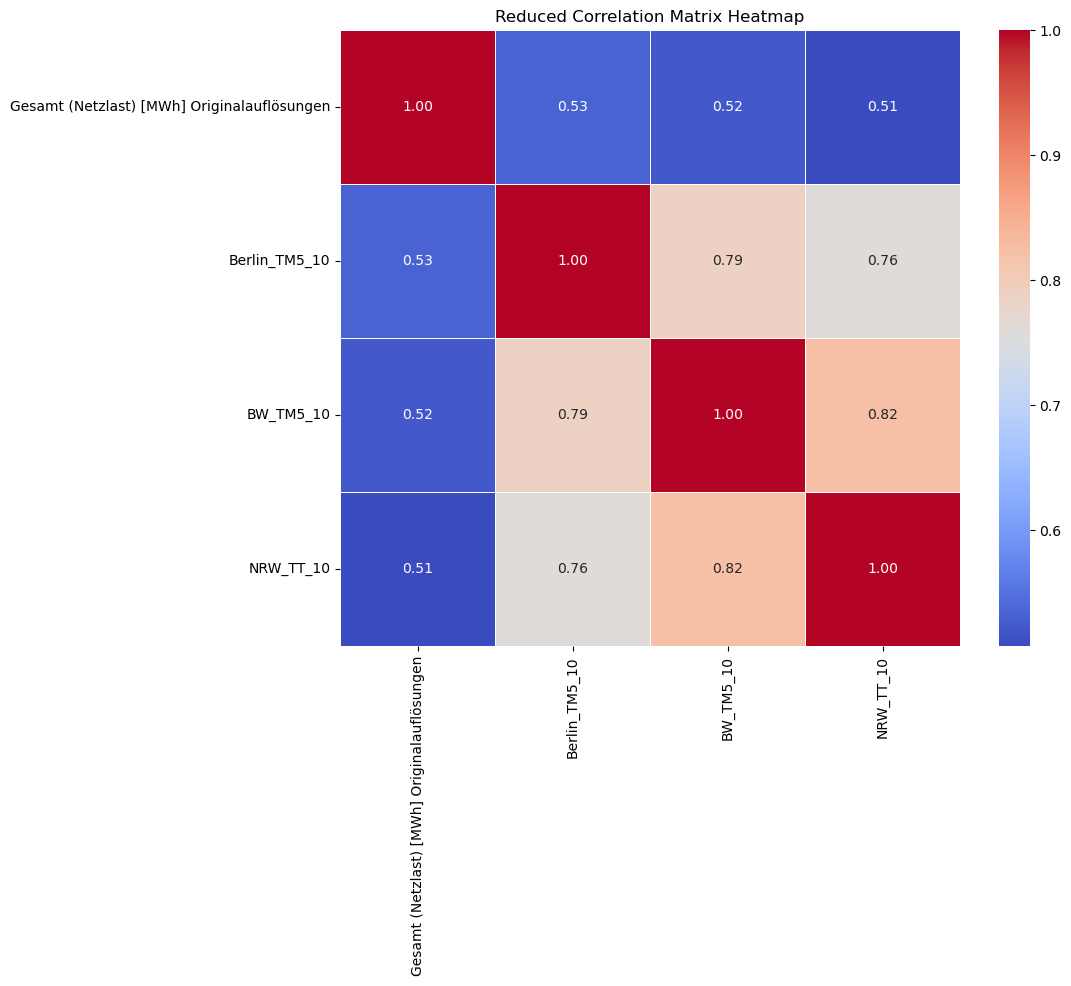

       Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime  \
0                                         11930.50 2016-06-10 00:00:00   
1                                         11764.50 2016-06-10 00:15:00   
2                                         11602.50 2016-06-10 00:30:00   
3                                         11495.00 2016-06-10 00:45:00   
4                                         11384.25 2016-06-10 01:00:00   
...                                            ...                 ...   
12187                                     11220.50 2024-07-14 22:45:00   
12188                                     11049.50 2024-07-14 23:00:00   
12189                                     10986.00 2024-07-14 23:15:00   
12190                                     10838.75 2024-07-14 23:30:00   
12191                                     10626.50 2024-07-14 23:45:00   

         Land1    Land2   Runde Liga Land3 Land4  Berlin_TM5_10  BW_TM5_10  \
0          NaN      NaN     NaN  

In [51]:
# Set the correlation threshold
correlation_threshold = 0.9 # Adjust this threshold as needed
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
#print(df_filtered)
reduce_input_df = df_filtered.copy()
df_reduced = reducing_dimensionality(df_filtered, correlation_threshold,categorical_columns)

print("done")

## 2.3 Normalizing Data 

In [52]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]

columns_to_normalize = [col for col in df_reduced.columns if not any(excl in col for excl in categorical_columns)]
scaler = MinMaxScaler()
# Scale the entire dataframe
df_normalized = df_reduced.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])



print("done")


done



## 2.4 Extracting Features out of DateTime

In [53]:
df_time_feature = df_normalized.copy()


df_time_feature['year'] = df_time_feature['DateTime'].dt.year
df_time_feature['month'] = df_time_feature['DateTime'].dt.month
df_time_feature['day'] = df_time_feature['DateTime'].dt.day
df_time_feature['hour'] = df_time_feature['DateTime'].dt.hour
df_time_feature['minute'] = df_time_feature['DateTime'].dt.minute
df_time_feature['day_of_week'] = df_time_feature['DateTime'].dt.dayofweek
df_time_feature['week_of_year'] = df_time_feature['DateTime'].dt.isocalendar().week
df_time_feature['is_weekend'] = df_time_feature['DateTime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

df_2024_datetime = df_time_feature[df_time_feature['year'] == 2024]
df_2024_datetime = df_2024_datetime["DateTime"]

df_time_feature.drop(columns = ["DateTime"], inplace = True)



print(df_2024_datetime)

# Drop original datetime if you won't need it
print("done")

9024    2024-06-12 00:00:00
9025    2024-06-12 00:15:00
9026    2024-06-12 00:30:00
9027    2024-06-12 00:45:00
9028    2024-06-12 01:00:00
                ...        
12187   2024-07-14 22:45:00
12188   2024-07-14 23:00:00
12189   2024-07-14 23:15:00
12190   2024-07-14 23:30:00
12191   2024-07-14 23:45:00
Name: DateTime, Length: 3168, dtype: datetime64[ns]
done


## 2.5 Encoding categorical values

### 2.5.1 One-Hot Encoding

In [54]:
hot_encoded_df = df_time_feature.copy()
categorical_columns = ["Runde", "Liga"]
hot_encoded_df = pd.get_dummies(hot_encoded_df, columns = categorical_columns)
print("done")

done


### 2.5.2 Ordinal Encoding

In [55]:
#print(football_dic)

temp_path =r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'

football_dic_copy = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)

country_to_rank = ranking_countries_by_viewership(football_dic_copy)

encoding_columns = ["Land1", "Land2", "Land3", "Land4"]

ordinal_encoded_df = hot_encoded_df.copy()
for column in encoding_columns:
    ordinal_encoded_df[f'{column}_rank'] = ordinal_encoded_df[column].map(country_to_rank)
    
print(ordinal_encoded_df.columns)

df_encoded = ordinal_encoded_df.drop(columns= encoding_columns)
print(len(df_encoded.columns))

df_2024 = df_encoded[df_encoded['year'] == 2024]
deviation_factor = 0.05  # 5% deviation

# Apply Gaussian noise to each value
# The noise will have mean 0 and standard deviation = deviation_factor * actual value
#df_predictions = df_2024.apply(lambda x: x + np.random.normal(0, deviation_factor * x))
# Optionally, create another DataFrame that contains the rows where 'year' is not 2024
df_not_2024 = df_encoded[df_encoded['year'] != 2024]

#print(df_2024)
print(df_not_2024.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Land1', 'Land2',
       'Land3', 'Land4', 'Berlin_TM5_10', 'BW_TM5_10', 'NRW_TT_10', 'year',
       'month', 'day', 'hour', 'minute', 'day_of_week', 'week_of_year',
       'is_weekend', 'Runde_Achtelfinale', 'Runde_Finale',
       'Runde_Gruppenphase', 'Runde_Halbfinale', 'Runde_Spiel um Platz 3',
       'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank',
       'Land3_rank', 'Land4_rank'],
      dtype='object')
24
Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'day', 'hour', 'minute',
       'day_of_week', 'week_of_year', 'is_weekend', 'Runde_Achtelfinale',
       'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
       'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM',
       'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank'],
      dtype='object')


### 2.5.3 Cyclic Encoding

In [56]:

categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
columns_to_normalize = ["year", 'week_of_year', 'month' ]

df_normalized_cyclic = cyclic_encoding(df_not_2024, categorical_columns, columns_to_normalize)
df_normalized_cyclic.fillna(0, inplace=True)

print(df_normalized_cyclic.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year', 'is_weekend',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')


In [57]:
# Definieren der kategorischen Spalten und der Spalten, die normalisiert werden sollen
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
columns_to_normalize = ["year", 'week_of_year', 'month' ]

# Anwenden der zyklischen Kodierung und Normalisierung auf den DataFrame df_2024
df_normalized_cyclic_new = cyclic_encoding(df_2024, categorical_columns, columns_to_normalize)

# Ersetzen von fehlenden Werten im DataFrame df_normalized_cyclic durch 0
df_normalized_cyclic_new.fillna(0, inplace=True)

# Ausgabe der Spaltennamen des neuen DataFrames nach der Kodierung und Normalisierung
print(df_normalized_cyclic_new.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year', 'is_weekend',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')


# 3. Modelling

In [58]:
%run Modelling.ipynb
%run Visualization.ipynb

## 3.1 Linear Regression

Dieser Code führt eine Zeitreihenaufteilung durch, trainiert ein lineares Regressionsmodell und bewertet es mit den Metriken Mean Squared Error (MSE) und R^2 Score. Anschließend werden die Ergebnisse visualisiert.

## 3.1.1 Importieren der Bibliotheken 

In [161]:
# Importieren von TimeSeriesSplit für Zeitreihenaufteilung
from sklearn.model_selection import TimeSeriesSplit

# Importieren des linearen Regressionsmodells
from sklearn.linear_model import LinearRegression

# Importieren von Metriken zur Modellbewertung
from sklearn.metrics import mean_squared_error, r2_score

### 3.1.2 Vorbereitung der Daten

In [162]:
# Auswählen der unabhängigen Variablen (Features) aus dem DataFrame
X = df_normalized_cyclic[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

# Abhängige Variable (Zielvariable)
y = df_normalized_cyclic['Gesamt (Netzlast) [MWh] Originalauflösungen']
# Auffüllen fehlender Werte mit 0
X = X.fillna(0)  


### 3.1.3 Modellierung und Bewertung

Train index: 1503, Test index: 3007
Mean Squared Error: 1.0366450083244323
R^2 Score: -15.474182874795158
Train index: 3007, Test index: 4511
Mean Squared Error: 0.02799856887541316
R^2 Score: 0.5605127858989647
Train index: 4511, Test index: 6015
Mean Squared Error: 0.021013410588822355
R^2 Score: 0.6621996997378272
Train index: 6015, Test index: 7519
Mean Squared Error: 0.015050824269454347
R^2 Score: 0.7010460003207285
Train index: 7519, Test index: 9023
Mean Squared Error: 0.014704712164937133
R^2 Score: 0.736341134453101
Average Mean Squared Error: 0.22308250484461184
Average R^2 Score: -2.5628166508769072


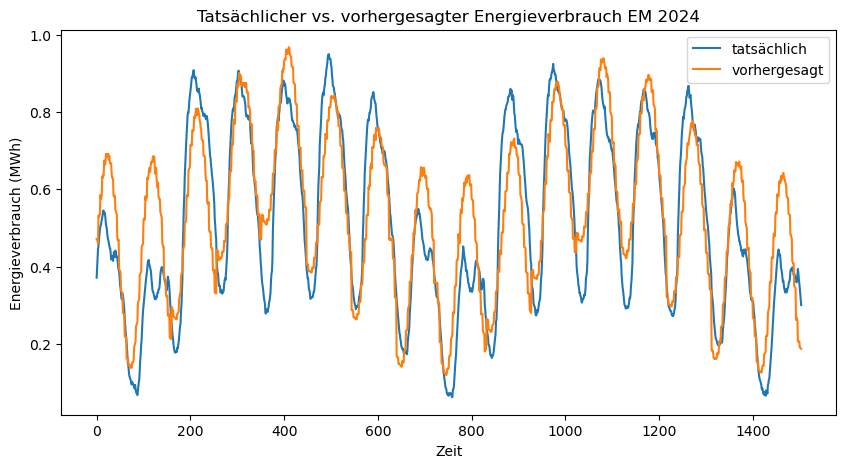

In [163]:
# Listen zur Speicherung der Mean Squared Error und R^2 Werte Werte
mse_scores = []
r2_scores = []

# Zeitreihenaufteilung mit TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
lr_model = LinearRegression()

# Iteration über die Aufteilungen in Train und Test Daten
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modell trainieren
    lr_model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred_lr = lr_model.predict(X_test)
    
    # Bewertung
    mse = mean_squared_error(y_test, y_pred_lr)
    r2 = r2_score(y_test, y_pred_lr)
    
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    # Ausgabe der Indizes und Metriken
    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    
# Ausgabe der durchschnittlichen Metriken über alle Splits
print(f"Average Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average R^2 Score: {np.mean(r2_scores)}")

# Visualisierung der letzten Vorhersage
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="tatsächlich") # Plotten der tatsächlichen Werte
plt.plot(y_pred_lr, label="vorhergesagt") # Plotten der vorhergesagten Werte
plt.legend() # Hinzufügen der Legende
plt.xlabel("Zeit")
plt.ylabel("Energieverbrauch (MWh)")
plt.title("Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024")
plt.show() # Anzeigen der Grafik



### 3.1.4 Vorhersage der EM 2024

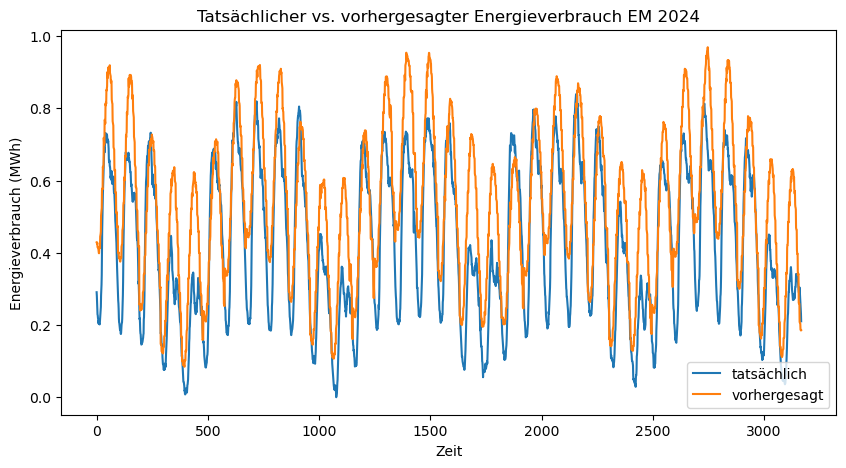

In [164]:
data_2024 = df_normalized_cyclic_new[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

# Fülle fehlende Werte in den neuen Daten auf
data_2024 = data_2024.fillna(0)

# Verwende das bereits trainierte Modell für Vorhersagen
y_pred_lr = lr_model.predict(data_2024)

# Zeige die Vorhersagen an
plt.figure(figsize=(10, 5))

#Gegenüberstellung der u simulierten Daten mit dem tatsächlichen Verbrauch während der EM 2024
y_2024 = df_normalized_cyclic_new['Gesamt (Netzlast) [MWh] Originalauflösungen']
plt.plot(y_2024.values, label="tatsächlich")

# Visualisierung des simulierten Verbrauchs
plt.plot(y_pred_lr, label="vorhergesagt")
plt.legend()
plt.title("Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024") # Titel der Grafik
plt.xlabel("Zeit")
plt.ylabel("Energieverbrauch (MWh)")
plt.show() # Anzeigen der Grafik


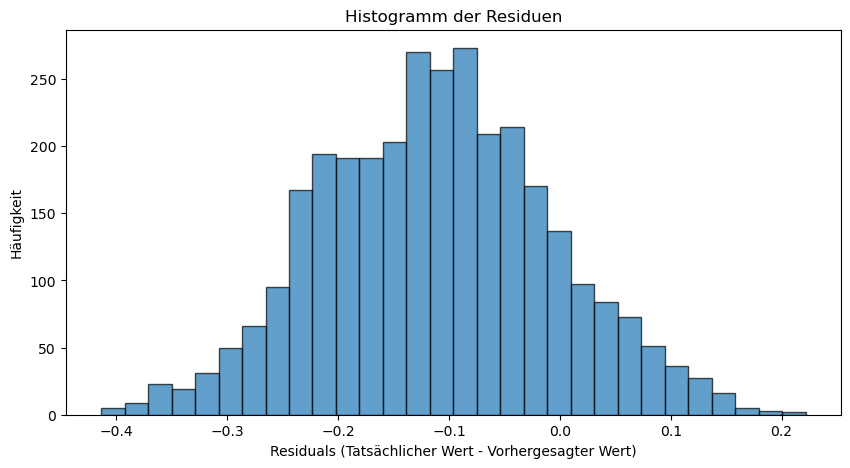

In [165]:
# Berechnung der Residuen
residuals = y_2024.values - y_pred_lr

# Plotten des Histogramms der Residuen
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals (Tatsächlicher Wert - Vorhergesagter Wert)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der Residuen')
plt.show()


## 3.2 Random Forest

Dieser Code führt eine Zeitreihenaufteilung durch, trainiert ein Random Forest Regressor Modell und bewertet es mit den Metriken MSE und R^2 Score. Anschließend werden die Ergebnisse visualisiert.

### 3.2.1 Modellierung und Bewertung


Train index: 1503, Test index: 3007
Mean Squared Error: 0.0011854742225908901
R^2 Score: 0.9811606490365641
Train index: 3007, Test index: 4511
Mean Squared Error: 0.0020023131099030055
R^2 Score: 0.968570143197497
Train index: 4511, Test index: 6015
Mean Squared Error: 0.0012091867002812075
R^2 Score: 0.9805617641790481
Train index: 6015, Test index: 7519
Mean Squared Error: 0.002683350051688956
R^2 Score: 0.9467007111284892
Train index: 7519, Test index: 9023
Mean Squared Error: 0.0014537775697907904
R^2 Score: 0.9739334343638133
Average Mean Squared Error: 0.0017068203308509698
Average R^2 Score: 0.9701853403810823


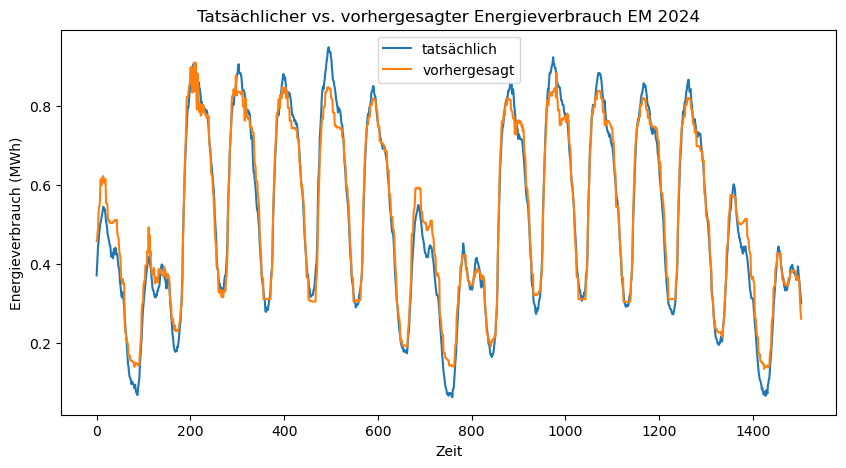

In [197]:
# Listen zur Speicherung der Fehlermaße
mse_scores = []
r2_scores = []

# Zeitreihenaufteilung mit TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) # Aufteilen der Daten in 5 Teile
#rf_model = RandomForestRegressr(n_estimators=200, random_state=42)  # Initialisieren des Random Forest Modells
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=10,             # Begrenzung der maximalen Tiefe der Bäume
    min_samples_split=5,     # Mindestanzahl von Proben, um einen Knoten zu teilen
    min_samples_leaf=1,       # Mindestanzahl von Proben in einem Blatt
    max_features='auto'       # Anzahl der zu betrachtenden Features pro Split
)

# Iteration über die Aufteilungen
for train_index, test_index in tscv.split(X):
    # Aufteilen der Features und Zielvariable in Trainings- und Testdaten
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modell trainieren
    rf_model.fit(X_train, y_train)
    
    # Vorhersage durch Random Forest
    y_pred_rf = rf_model.predict(X_test)
    
    # Bewertung
    mse = mean_squared_error(y_test, y_pred_rf)
    r2 = r2_score(y_test, y_pred_rf)
    
    # Speichern der Fehlermaße
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    # Ausgabe der Indizes und Metriken
    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    
# Ausgabe der durchschnittlichen Metriken über alle Splits
print(f"Average Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average R^2 Score: {np.mean(r2_scores)}")

# Visualisierung der letzten Vorhersage
plt.figure(figsize=(10, 5))  # Festlegen der Größe der Grafik
plt.plot(y_test.values, label="tatsächlich")  # Plotten der tatsächlichen Werte
plt.plot(y_pred_rf, label="vorhergesagt")  # Plotten der vorhergesagten Werte
plt.legend() # Hinzufügen der Legende
plt.title("Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024") # Titel der Grafik
plt.xlabel("Zeit")
plt.ylabel("Energieverbrauch (MWh)")
plt.show() # Anzeigen der Grafik

### 3.2.2 Vergleich von Training- und Testfehlern

In [198]:
mse_train_scores = []
r2_train_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf_model.fit(X_train, y_train)
    
    y_pred_train = rf_model.predict(X_train)
    y_pred_rf = rf_model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_rf)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_rf)
    
    mse_train_scores.append(mse_train)
    r2_train_scores.append(r2_train)
    mse_scores.append(mse_test)
    r2_scores.append(r2_test)
    
    print(f"Train MSE: {mse_train}, Test MSE: {mse_test}")
    print(f"Train R²: {r2_train}, Test R²: {r2_test}")

Train MSE: 7.17720673364784e-05, Test MSE: 0.0011854742225908901
Train R²: 0.9988259592999988, Test R²: 0.9811606490365641
Train MSE: 8.812860223404739e-05, Test MSE: 0.0020023131099030055
Train R²: 0.9985793881693164, Test R²: 0.968570143197497
Train MSE: 0.000133941466724565, Test MSE: 0.0012091867002812075
Train R²: 0.9978840647852342, Test R²: 0.9805617641790481
Train MSE: 0.0001691660069137799, Test MSE: 0.002683350051688956
Train R²: 0.9973192300863953, Test R²: 0.9467007111284892
Train MSE: 0.0002605400810582485, Test MSE: 0.0014537775697907904
Train R²: 0.9956973623708292, Test R²: 0.9739334343638133


### 3.2.3 Learning Curves

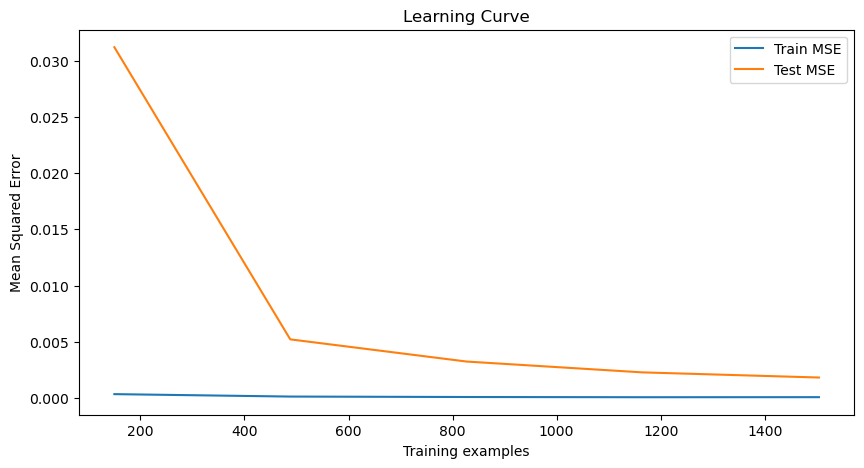

In [199]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X, y, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_scores_mean, label="Train MSE")
plt.plot(train_sizes, test_scores_mean, label="Test MSE")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("Learning Curve")
plt.show()

### 3.2.4 Hyperparameter Tuning

In [196]:
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [100, 200, 300]
}

# RandomizedSearchCV mit Regularisierungsparametern
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X, y)

# Beste Hyperparameter ausgeben
print("Beste Hyperparameter: ", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Beste Hyperparameter:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10}


- Der Code trainiert ein Random Forest Regressionsmodell auf einer Zeitreihen-Dataset.
- Die Daten werden in 5 Splits aufgeteilt, wobei jeweils ein Teil als Testdaten und der Rest als Trainingsdaten genutzt wird.
- Das Modell wird für jeden Split trainiert und bewertet (mittels MSE und R²).
- Durchschnittliche Fehlermaße werden berechnet und die Vorhersagen des letzten Splits visualisiert.

### 3.2.3 Vorhersage der EM 2024


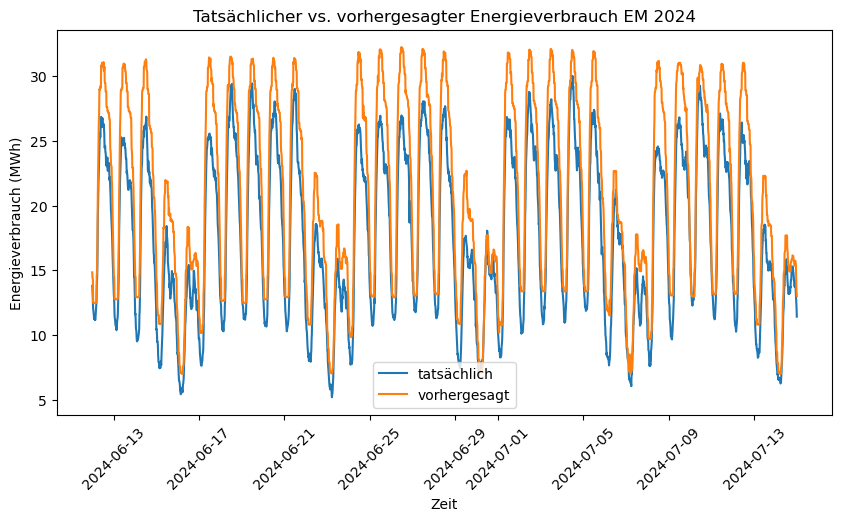

In [202]:
# Vorhersage des Verbrauchs während der EM 2024
y_pred_rf = model.predict(data_2024)

#Gegenüberstellung der u simulierten Daten mit dem tatsächlichen Verbrauch während der EM 2024

plt.figure(figsize=(10, 5))

y_2024 = df_normalized_cyclic_new['Gesamt (Netzlast) [MWh] Originalauflösungen']
y_2024_new_reshaped = y_2024.values.reshape(-1, 1)

# Create a new MinMaxScaler instance for the target feature
scaler_target = MinMaxScaler()

# Set the min_ and scale_ using the last column of the original scaler
# These values need to be arrays, so we wrap them in np.array() and reshape
scaler_target.min_ = np.array([scaler.min_[-1]])
scaler_target.scale_ = np.array([scaler.scale_[-1]])

# Perform the inverse transformation on the reshaped target variable
y_2024_original = scaler_target.inverse_transform(y_2024_new_reshaped)
plt.plot(df_2024_datetime, y_2024_original, label="tatsächlich")

# Visualisierung des simulierten Verbrauchs
# Reshape y_pred_new into a 2D array
y_pred_rf_reshaped = y_pred_rf.reshape(-1, 1)

scaler_target = MinMaxScaler()
scaler_target.min_ = scaler.min_[-1]    # Extract min for target feature
scaler_target.scale_ = scaler.scale_[-1]  # Extract scale for target feature

# Perform the inverse transformation on the predicted target variable
y_pred_original = scaler_target.inverse_transform(y_pred_rf_reshaped)
# Reshape the result back into a 1D array if needed
#original_data = original_data.flatten()
plt.plot(df_2024_datetime, y_pred_original, label="vorhergesagt")

plt.legend()
plt.title("Tatsächlicher vs. vorhergesagter Energieverbrauch EM 2024") # Titel der Grafik
plt.xticks(rotation=45)
plt.xlabel("Zeit")
plt.ylabel("Energieverbrauch (MWh)")
plt.show() # Anzeigen der Grafik


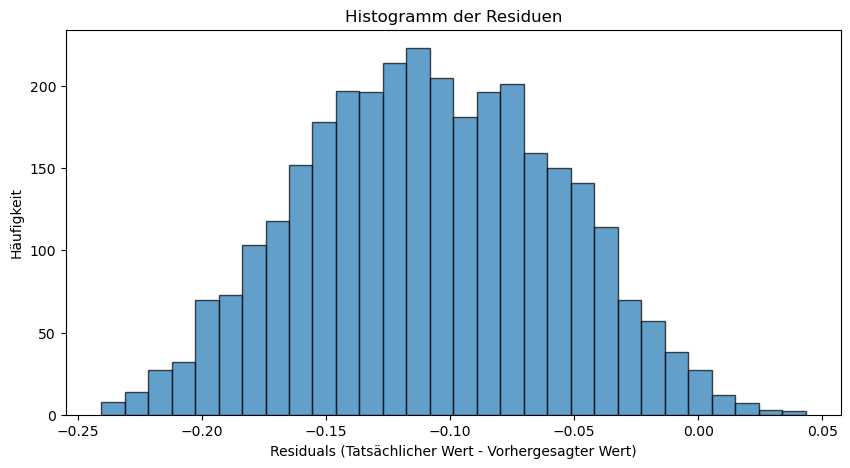

In [203]:

# Berechnung der Residuen
residuals = y_2024.values - y_pred_rf

# Plotten des Histogramms der Residuen
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals (Tatsächlicher Wert - Vorhergesagter Wert)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der Residuen')
plt.show()


Hier wurden die Vorhersagen des trainierten Modells für neue Daten erstellt und visualisiert. Indem der Spielplan und die Wetterdaten gegeben und der Verbrauch mit dem trainierten Modell vorhergesagt wird.



## 3.3 LSTM

### 3.3.1 Datentypen für LSTM anpassen

In [ ]:

bool_columns = ['Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
                'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
                'Liga_EM', 'Liga_WM']

df_normalized_cyclic[bool_columns] = df_normalized_cyclic[bool_columns].astype(int)

float_columns = ['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10', 'BW_TM5_10',
                  'NRW_TT_10', 'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank']

df_normalized_cyclic[float_columns] = df_normalized_cyclic[float_columns].astype(np.float32)

int_columns = ['year','hour_sin','hour_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin',
               'day_of_week_cos',"is_weekend", 'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
               'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM']

df_normalized_cyclic[int_columns] = df_normalized_cyclic[int_columns].astype(np.int32)

### 3.3.2 Dataframe in Sequenzen und Tensor umwandeln

In [ ]:

target_column = 'Gesamt (Netzlast) [MWh] Originalauflösungen'

# Separate features and target
X = df_normalized_cyclic.drop(columns=[target_column])
y = df_normalized_cyclic[target_column]

sequence_length = 96

# Create sequences
X_sequences, y_sequences = create_sequences(X.values, y.values, sequence_length)

# Reshape X for LSTM: [samples, time steps, features]
num_features = X_sequences.shape[2]  # Number of features
X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], num_features))

print(f'X_sequences shape: {X_sequences.shape}')
print(f'y_sequences shape: {y_sequences.shape}')


### 3.3.3 Festlegung der Modellarchitektur

In [ ]:
layers = 32
epochs = 20
regularization = 0.001
dropout = 0.3
learning_rate = 0.0005
early_stopping = 5

### 3.3.4 Train und Test Split mit Validierung

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
split_results = []

train_losses_per_split = []
val_losses_per_split = []

for train_index, test_index in tscv.split(X_sequences):

    X_train, X_test = X_sequences[train_index], X_sequences[test_index]
    y_train, y_test = y_sequences[train_index], y_sequences[test_index]


    history,model = lstm_model(X_train, X_test,y_train, y_test, layers, epochs, regularization, dropout, learning_rate, early_stopping)
    
    # Evaluate the model
    # Collect loss for plotting
    train_losses_per_split.append(history.history['loss'])
    val_losses_per_split.append(history.history['val_loss'])
    
    loss = model.evaluate(X_test, y_test)
    split_results.append(loss)

# Average performance over all splits
average_loss = np.mean(split_results)
print(f'Average validation loss over all splits: {average_loss}')

# Plot training and validation losses across splits
for i in range(len(train_losses_per_split)):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_per_split[i], label=f'Training Verlust (Split {i+1})')
    plt.plot(val_losses_per_split[i], label=f'Validation Verlust (Split {i+1})')
    plt.title(f'Training vs Validation Verlust für Split {i+1}')
    plt.xlabel('Epoche')
    plt.ylabel('Verust')
    plt.legend()
    plt.show()

### 3.3.5 Finales Model

In [ ]:

# Assuming the model performed well, we now train on the entire dataset (except the final test set)
train_size = int(len(X_sequences) * 0.9)
X_train_final, X_test_final = X_sequences[:train_size], X_sequences[train_size:]
y_train_final, y_test_final = y_sequences[:train_size], y_sequences[train_size:]


lstm_final, model_final = lstm_model(X_train_final, X_test_final,y_train_final, y_test_final, layers, epochs, regularization, dropout, learning_rate, early_stopping)


# Final evaluation
final_loss = model_final.evaluate(X_test_final, y_test_final)
print(f'Final test loss: {final_loss}')

y_pred = model_final.predict(X_test_final)
r2 = r2_score(y_test_final, y_pred)

print(f'R² Score: {r2}')




In [ ]:
# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_final, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted Values', color='red', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')


### 3.3.6 Vorhersage der EM 2024 

In [ ]:

bool_columns = ['Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
                'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
                'Liga_EM', 'Liga_WM']

df_normalized_cyclic_new[bool_columns] = df_normalized_cyclic_new[bool_columns].astype(int)

float_columns = ['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10', 'BW_TM5_10',
                  'NRW_TT_10', 'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank']

df_normalized_cyclic_new[float_columns] = df_normalized_cyclic_new[float_columns].astype(np.float32)

int_columns = ['year','hour_sin','hour_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin',
               'day_of_week_cos',"is_weekend", 'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
               'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM']

df_normalized_cyclic_new[int_columns] = df_normalized_cyclic_new[int_columns].astype(np.int32)

In [ ]:
target_column = 'Gesamt (Netzlast) [MWh] Originalauflösungen'

# Separate features and target
#print(df_normalized_cyclic_new)
X = df_normalized_cyclic_new.drop(columns=[target_column])
y = df_normalized_cyclic_new[target_column]

sequence_length = 96

# Create sequences
X_sequences_em, y_sequences_em = create_sequences(X.values, y.values, sequence_length)
#print(X_sequences)

num_features = X_sequences_em.shape[2]  # Number of features
X_sequences_em = X_sequences_em.reshape((X_sequences_em.shape[0], X_sequences_em.shape[1], num_features))

print(f'X_sequences shape: {X_sequences_em.shape}')
#print(f'y_sequences shape: {y_sequences.shape}')

y_pred_2024 = model_final.predict(X_sequences_em)

print("done")

In [ ]:
# Assuming y_pred_lstm is your LSTM model's prediction and it's normalized

# Reshape the LSTM predictions to match the required input shape for inverse_transform
y_pred_lstm_reshaped = y_pred_2024.reshape(-1, 1)

# Create a new MinMaxScaler instance for the target feature (like in random forest case)
scaler_target = MinMaxScaler()

# Set the min_ and scale_ from your original scaler
scaler_target.min_ = np.array([scaler.min_[-1]])   # Set min for target feature
scaler_target.scale_ = np.array([scaler.scale_[-1]])  # Set scale for target feature

# Perform the inverse transformation on the reshaped LSTM predictions
y_pred_lstm_original = scaler_target.inverse_transform(y_pred_lstm_reshaped)



y_pred_lstm_reshaped = y_sequences_em.reshape(-1, 1)

# Create a new MinMaxScaler instance for the target feature (like in random forest case)
scaler_target = MinMaxScaler()

# Set the min_ and scale_ from your original scaler
scaler_target.min_ = np.array([scaler.min_[-1]])   # Set min for target feature
scaler_target.scale_ = np.array([scaler.scale_[-1]])  # Set scale for target feature

# Perform the inverse transformation on the reshaped LSTM predictions
y_sequence_lstm_original = scaler_target.inverse_transform(y_pred_lstm_reshaped)

In [ ]:
first_data =  y_sequence_lstm_original
second_data = y_pred_lstm_original
xaxis_data = df_2024_datetime_trimmed = df_2024_datetime.iloc[96:]
first_label = "Tatsächliche Werte"
second_label = "Vorhergesagte Werte"
title =  "EM2024 Tatsächlich vs. Vorhersage"
xaxis = "Datum"
yaxis = "MWh in mio."
em_plot = plot_two_lines(first_data, second_data, xaxis_data, first_label, second_label, title, xaxis, yaxis)
em_plot.show()



In [ ]:
# Berechnung der Residuen
residuals_lstm = y_sequence_lstm_original - y_pred_lstm_original

# Plotten des Histogramms der Residuen
plt.figure(figsize=(10, 5))
plt.hist(residuals_lstm, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals (Tatsächlicher Wert - Vorhergesagter Wert)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der Residuen')
plt.show()
